In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import make_grid, save_image
from PIL import Image
import matplotlib.pyplot as plt
import os

## Custom Data Loader

In [3]:
img_size = 128
data_path = './Dataset/'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Grayscale(),
    transforms.Resize((img_size,img_size))])

class CustomLoader(torch.utils.data.Dataset):
    def __init__(self, data_path, transform):
        self.path = data_path
        self.files = []
        for dir_path, currentDirectory, dir_files in os.walk(data_path):
            for file in dir_files:
                self.files.append(dir_path + '/' + file)
        self.indices = len(self.files)
        self.transform = transform

    def __getitem__(self, idx):
        image = Image.open(self.files[idx]).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        label = int(self.files[idx].split('-')[0][-1:])

        return image, torch.tensor(label).long()

    def __len__(self):
        return self.indices

transformed_dataset = CustomLoader(data_path, transform)

dataloader = torch.utils.data.DataLoader(transformed_dataset, batch_size=32, shuffle=True)

tensor(1)


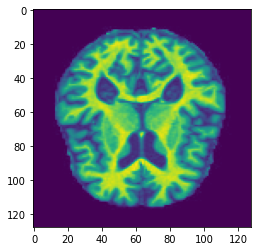

In [4]:
data = CustomLoader(data_path, transform)
im, label = data[6100]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

## CGAN model

In [12]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch

latent_dim = 100
n_classes = 4
img_shape = (1, img_size, img_size)
lr = 0.0002
b1 = 0.5
b2 = 0.999
cuda = True if torch.cuda.is_available() else False
batch_size = 32
n_epochs = 10


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity


# Loss functions
adversarial_loss = torch.nn.MSELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor


# ----------
#  Training
# ----------

d_loss_history = []
g_loss_history = []

for epoch in range(1):
    print(epoch)
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        d_loss_history.append(d_loss.cpu().detach().numpy())
        g_loss_history.append(g_loss.cpu().detach().numpy())

0


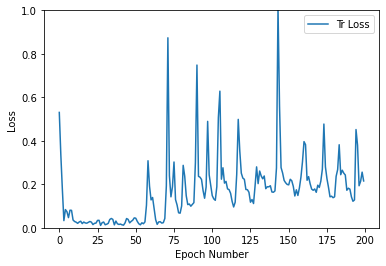

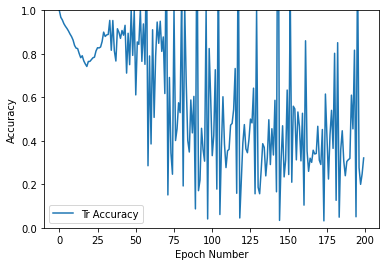

In [13]:
plt.plot(d_loss_history)
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig('./model/cgan/loss_curve.png')
plt.show()
plt.plot(np.array(g_loss_history))
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig('./model/cgan/accuracy_curve.png')
plt.show()

In [11]:
def sample_image(n_row, e):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    with torch.no_grad():
        # Sample noise
        z = Variable(FloatTensor(np.random.normal(0, 1, (n_row, latent_dim))))
        # Get labels ranging from 0 to n_classes for n rows
        labels_list = [0,1,2,3]
        labels = np.array(labels_list)
        labels = Variable(LongTensor(labels))
        gen_imgs = generator(z, labels)
        for label in range(len(labels_list)):
            save_image(gen_imgs.data[label], f"gan_images/{label}/{e}.png", normalize=True)

for i in range(20):
    sample_image(n_row=4, e=i)

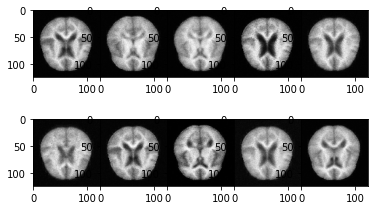

In [9]:
path = './images/0/'

images = [path + file for file in os.listdir(path)]

_, axs = plt.subplots(2, 5)
axs = axs.flatten()
for img, ax in zip(images, axs):
    image = plt.imread(img)
    ax.imshow(image)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

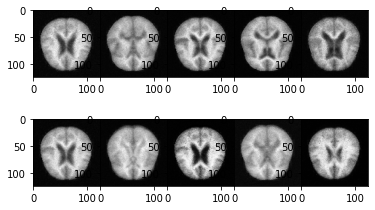

In [10]:
path = './images/1/'

images = [path + file for file in os.listdir(path)]

_, axs = plt.subplots(2, 5)
axs = axs.flatten()
for img, ax in zip(images, axs):
    image = plt.imread(img)
    ax.imshow(image)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [ ]:
PATH = "./model/cgan/model.pt"

torch.save({
    'generator': generator.state_dict(),
    'discriminator': discriminator.state_dict(),
    'optimizer_G': optimizer_G.state_dict(),
    'optimizer_D': optimizer_D.state_dict(),
}, PATH)